# Open-cell tests

In [7]:
%load_ext autoreload
%autoreload 2

# og python libs
import re
import os
import pprint
import itertools
from typing import Tuple, List, Dict, Pattern, Any, Sequence


# classic DS libs
import pandas as pd
import numpy as np

# viz libs
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager as font_manager
from ipywidgets import interact, fixed, interact_manual
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# scipy
from scipy.integrate import quad
from scipy.signal import find_peaks, peak_widths, find_peaks_cwt
from scipy.constants import k as k_B
from scipy.constants import c, pi, N_A, h, hbar, m_e, m_p

# lmfit things
from lmfit.models import LinearModel, GaussianModel, VoigtModel, SplineModel, ExponentialModel, ExpressionModel, Model, ConstantModel
from lmfit import Parameter, Parameters
from lmfit import minimize, minimizer

# ML
from sklearn.linear_model import LinearRegression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# custom
import sys
sys.path.append('../../../../')
from my_utils import defs as cp
from my_utils.classes import CEPAS_measurement, CEPAS_benchmark, CEPAS_noise_info, CEPAS_SNR_bench
cp.hello_test()

HAPI version: 1.2.2.3
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

# Test paths

In [4]:
ps = ["./" + i + "/" for i in cp.dir_match("./", "bypass")]
print(ps)
pattern = re.compile(r"./bypass_(\d+)(?:_([a-z]+))?(?:_([a-z]+))?")
bypass_open = [re.findall(pattern, p) for p in ps]
bypass_open

['./bypass_0/', './bypass_1000/', './bypass_5/', './bypass_5_short/', './bypass_5_short_redo/']


[[('0', '', '')],
 [('1000', '', '')],
 [('5', '', '')],
 [('5', 'short', '')],
 [('5', 'short', 'redo')]]

# Manual operations

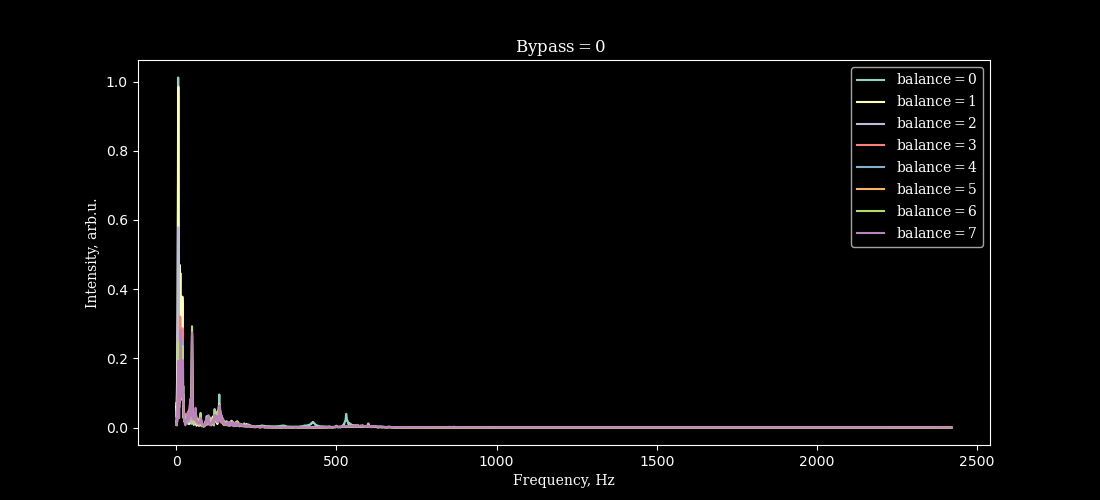

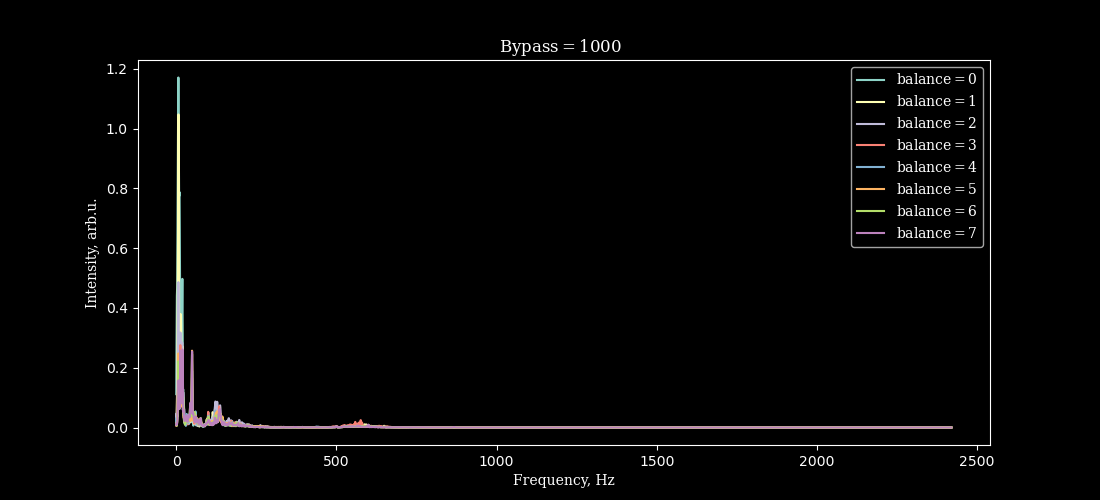

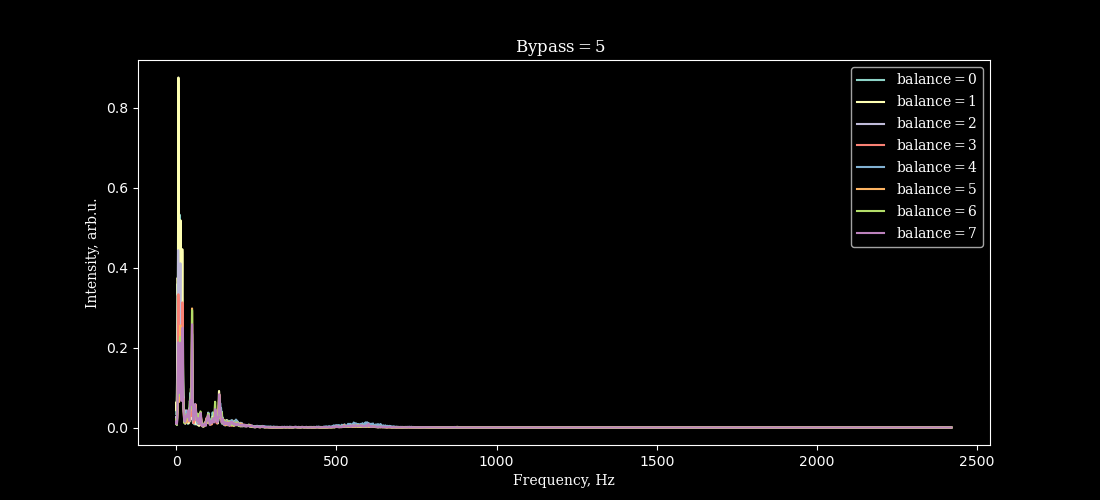

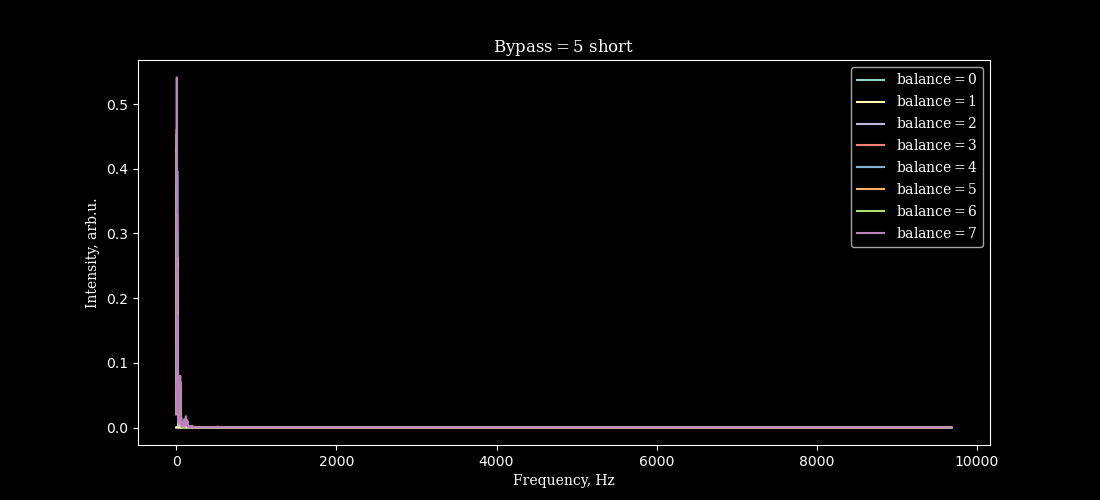

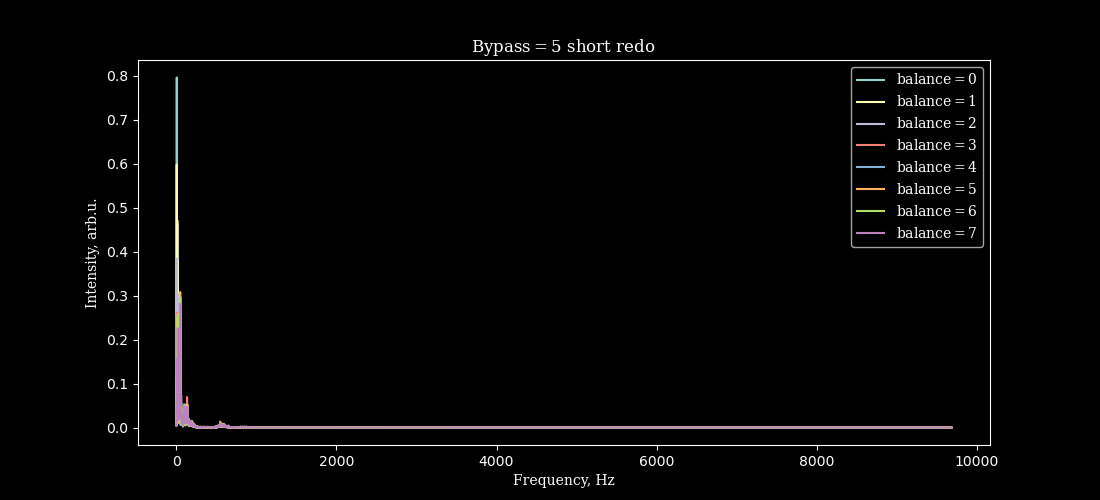

In [5]:
%matplotlib widget

matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'
font = font_manager.FontProperties(family='serif')



ps_dict = {ps[i]: cp.dir_match(ps[i], "spectrum_oc") for i in range(len(ps))}
# print(ps_dict)
plt.close()
for p_idx in range(len(ps)):
    values = list(ps_dict.values())
    # print(values)
    dfs_dict = {
        item[:-4]: pd.read_csv(ps[p_idx] + item,
                                    sep="\\s+",
                                    header=None,
                                    names=['Frequency', 'Intensity']
                                    ) for item in values[p_idx]}
    dfs_list = list(dfs_dict.values())
    dfs_keys = list(dfs_dict.keys())
    # print(dfs_list[0])

    plt.figure(figsize=(11, 5))


    for idx in range(len(dfs_list)):
        pattern = re.compile(r"^spectrum_oc_(\w+)_(\d+)$")
        balance_open = re.findall(pattern, dfs_keys[idx])[0][1]
        plt.plot(dfs_list[idx]['Frequency'],
                dfs_list[idx]['Intensity'],
                label=f"$\\text{{balance}}={balance_open}$")
        plt.xlabel("Frequency, Hz", fontname='serif')
        plt.ylabel("Intensity, arb.u.", fontname='serif')
    plt.legend(prop=font)
    


    plt.title(f"$\\text{{Bypass}}={bypass_open[p_idx][0][0]}$ {bypass_open[p_idx][0][1]} {bypass_open[p_idx][0][2]}",
              fontname='serif')
    plt.show()

## Integrals

[(0, 30), (40, 65)]
[0, 1, 2, 3, 4, 5, 6, 7]


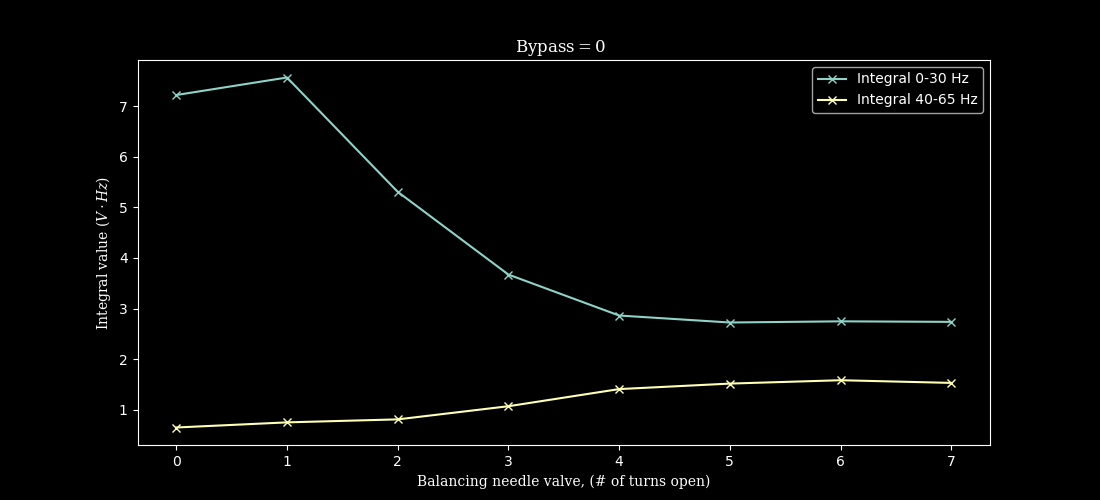

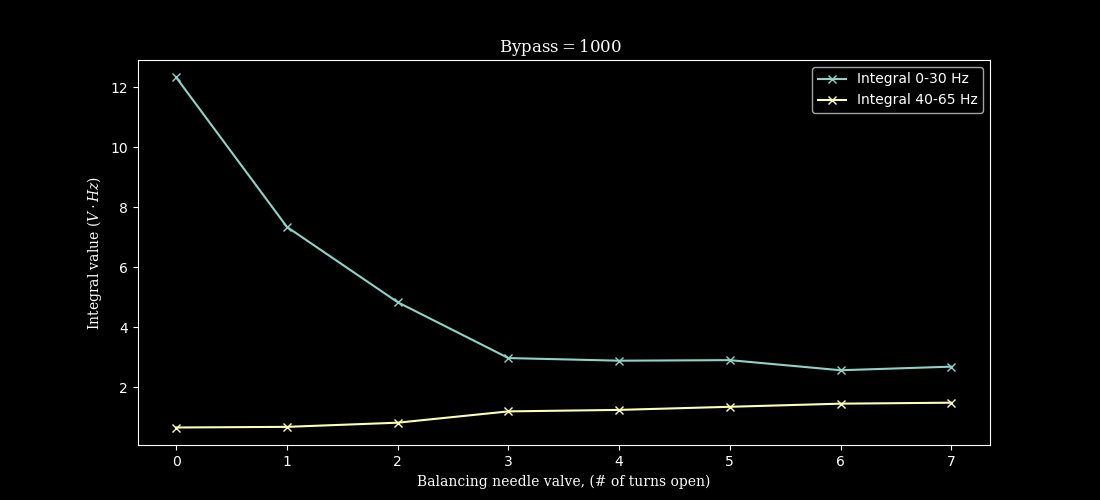

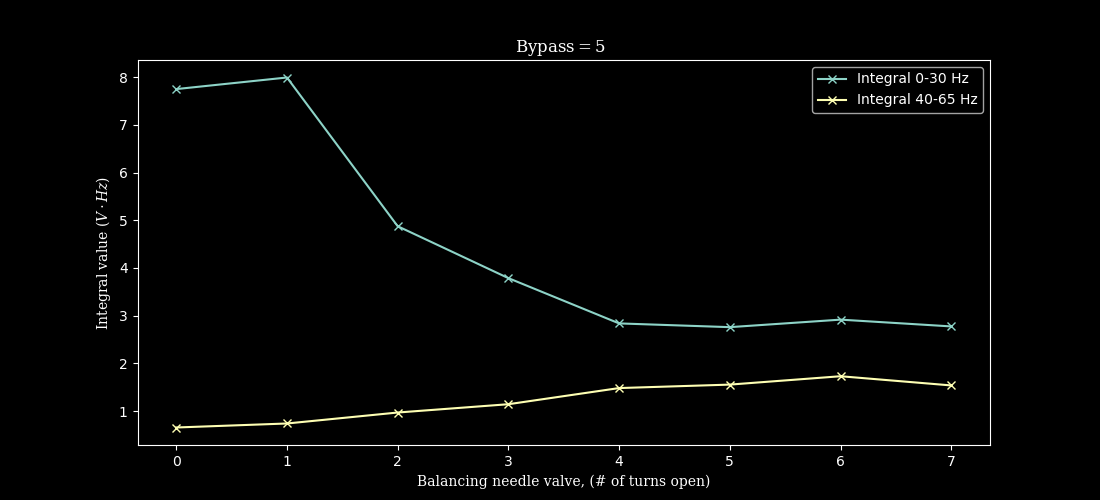

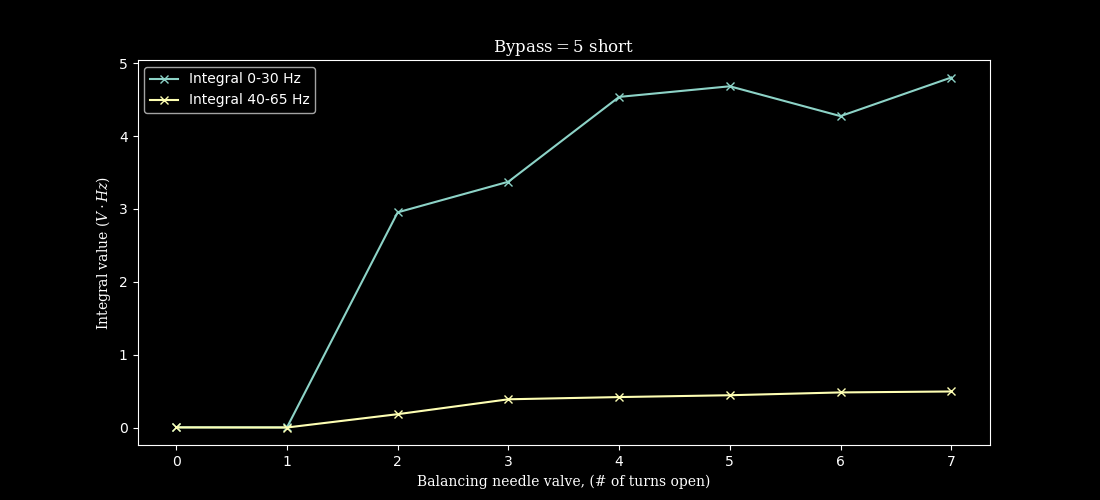

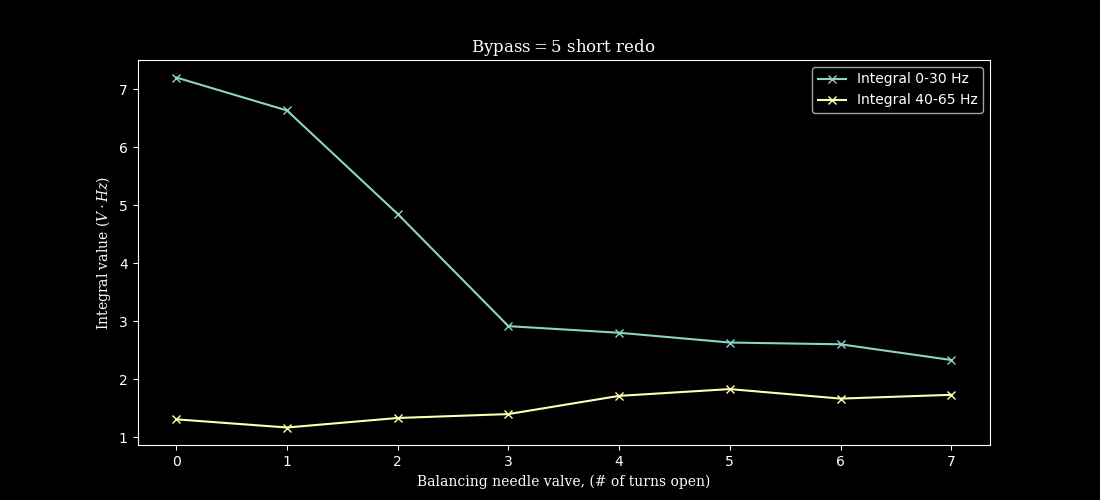

In [8]:
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'  # type: ignore # noqa: F821
font = font_manager.FontProperties(family='serif')

s = [0, 40]  # start
f = [30, 65]  # finish/end

print(list(zip(s, f)))

bypass_max = 7
bypass_amounts = list(range(bypass_max+1))
print(bypass_amounts)

plt.close()
for p_idx in range(len(ps)):
    values = list(ps_dict.values())
    # print(values)
    dfs_dict = {
        item[:-4]: pd.read_csv(ps[p_idx] + item,
                                    sep="\\s+",
                                    header=None,
                                    names=['Frequency', 'Intensity']
                                    ) for item in values[p_idx]}
    dfs_list = list(dfs_dict.values())

    integrals = [
        [
            cp.integrate_range_of(
                df, s, f, 'Frequency', 'Intensity'
             ) for df in dfs_list
         ] for s, f in zip(s, f)]

    integrals_dict: Dict[str, Sequence] = {
        'Bypass': bypass_amounts
    }


    for i in range(len(integrals)):
        integrals_dict[f'Integral {s[i]}-{f[i]} Hz'] = integrals[i]
    
    df_integrals = pd.DataFrame(integrals_dict)

    plt.figure(figsize=(11, 5))


    plt.plot(df_integrals['Bypass'], df_integrals.iloc[:,1], marker='x', label=f"{df_integrals.iloc[:,1].name}")
    plt.plot(df_integrals['Bypass'], df_integrals.iloc[:,2], marker='x', label=f'{df_integrals.iloc[:,2].name}')

    plt.xlabel("Balancing needle valve, (# of turns open)", fontname='serif')
    plt.ylabel("Integral value ($V \\cdot Hz$)", fontname='serif')

    plt.legend()
    plt.title(f"$\\text{{Bypass}}={bypass_open[p_idx][0][0]}$ {bypass_open[p_idx][0][1]} {bypass_open[p_idx][0][2]}",
              fontname='serif')

    plt.show()